In [19]:
import csv
import xml.etree.ElementTree as ET
import os
from collections import defaultdict

In [20]:
# Dataset paths
DATASET_ROOT = 'msr2013-bug_dataset-master/data'
MOZILLA_PATH = os.path.join(DATASET_ROOT, 'mozilla')
ECLIPSE_PATH = os.path.join(DATASET_ROOT, 'eclipse')

In [21]:
# File paths 
ASSIGNED_TO_FILE = 'assigned_to.xml'
BUG_STATUS_FILE = 'bug_status.xml'
SHORT_DESC_FILE = 'short_desc.xml'
SEVERITY_FILE = 'severity.xml'
PRIORITY_FILE = 'priority.xml'
OUTPUT_CSV = 'bug_reports_anonymized_v1.csv'

In [22]:
# Drop rows that has values other than p1,p2,p3,p4 or p5 in priority column
VALID_PRIORITIES = ['P1', 'P2', 'P3', 'P4', 'P5']

In [23]:
# Helper function to parse XML and extract the latest update for each report
def parse_latest_updates(file_path, tag, id_attr, value_tag):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        result = {}

        for report in root.findall('report'):
            report_id = report.get(id_attr)
            latest_update = None
            for update in report.findall('update'):
                when = int(update.find('when').text)
                what = update.find(value_tag).text
                if not latest_update or when > latest_update[0]:
                    latest_update = (when, what)

            if latest_update:
                result[report_id] = latest_update[1]

        return result
    except Exception as e:
        print(f"Error parsing {file_path}: {str(e)}")
        return {}

In [24]:
# Parse assigned_to.xml
def parse_assigned_to(file_path):
    return parse_latest_updates(file_path, 'report', 'id', 'what')

In [25]:
# Parse bug_status.xml (only RESOLVED bugs)
def parse_resolved_bugs(file_path):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        resolved_bugs = {}

        for report in root.findall('report'):
            report_id = report.get('id')
            resolved = False
            for update in report.findall('update'):
                what = update.find('what').text
                if what == 'RESOLVED':
                    resolved = True

            if resolved:
                resolved_bugs[report_id] = True

        return resolved_bugs
    except Exception as e:
        print(f"Error parsing {file_path}: {str(e)}")
        return {}

In [26]:
# Parse short_desc.xml
def parse_short_desc(file_path):
    return parse_latest_updates(file_path, 'report', 'id', 'what')

# Parse severity.xml
def parse_severity(file_path):
    return parse_latest_updates(file_path, 'report', 'id', 'what')

# Parse priority.xml
def parse_priority(file_path):
    return parse_latest_updates(file_path, 'report', 'id', 'what')

In [27]:
# Developer anonymization
developer_mapping = {}
next_developer_id = 1

def get_developer_id(email):
    global next_developer_id
    if email not in developer_mapping:
        developer_mapping[email] = f"developer_{next_developer_id:03d}"
        next_developer_id += 1
    return developer_mapping[email]

In [28]:
def process_project_folder(project_folder):
    print(f"Processing project folder: {project_folder}")
    
    # Initialize dictionaries to store data from all XML files in this project
    assigned_to = {}
    resolved_bugs = {}
    short_desc = {}
    severity = {}
    priority = {}
    
    # Process each XML file in the folder
    for root, dirs, files in os.walk(project_folder):
        for file in files:
            file_path = os.path.join(root, file)
            if file == ASSIGNED_TO_FILE:
                assigned_to.update(parse_assigned_to(file_path))
            elif file == BUG_STATUS_FILE:
                resolved_bugs.update(parse_resolved_bugs(file_path))
            elif file == SHORT_DESC_FILE:
                short_desc.update(parse_short_desc(file_path))
            elif file == SEVERITY_FILE:
                severity.update(parse_severity(file_path))
            elif file == PRIORITY_FILE:
                priority.update(parse_priority(file_path))
    
    # Filter only resolved bugs and gather required data
    rows = []
    for bug_id in resolved_bugs.keys():
        assigned_to_value = assigned_to.get(bug_id)
        severity_value = severity.get(bug_id)
        priority_value = priority.get(bug_id)
        
        # Skip if required fields are missing
        if (not assigned_to_value or not severity_value or not priority_value):
            #print(f"Skipping bug ID {bug_id} due to missing 'Assigned To' or 'Severity' or 'Priority'.")
            continue

        # Anonymize developer email
        developer_id = get_developer_id(assigned_to_value)
            
        row = {
            'bug_id': bug_id,
            'description': short_desc.get(bug_id, 'N/A'),
            'developer': developer_id,
            'severity': severity.get(bug_id, 'N/A'),
            'priority': priority.get(bug_id, 'N/A'),
            'project': os.path.basename(project_folder)
        }
        rows.append(row)
    
    return rows

In [29]:
def main():
    all_rows = []
    
    # Process all Mozilla projects
    for project in os.listdir(MOZILLA_PATH):
        project_path = os.path.join(MOZILLA_PATH, project)
        if os.path.isdir(project_path):
            all_rows.extend(process_project_folder(project_path))
    
    # Process all Eclipse projects
    for project in os.listdir(ECLIPSE_PATH):
        project_path = os.path.join(ECLIPSE_PATH, project)
        if os.path.isdir(project_path):
            all_rows.extend(process_project_folder(project_path))
    
    # Write to CSV
    if all_rows:
        fieldnames = ['bug_id', 'description', 'developer', 'severity', 'priority', 'project']
        with open(OUTPUT_CSV, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(all_rows)
        
        print(f"CSV file generated: {OUTPUT_CSV}")
        print(f"Total bug reports processed: {len(all_rows)}")
        print(f"Total unique developers: {len(developer_mapping)}")
    else:
        print("No valid data to write.")

if __name__ == '__main__':
    main()

Processing project folder: msr2013-bug_dataset-master/data/mozilla/Firefox
Processing project folder: msr2013-bug_dataset-master/data/mozilla/Core
Processing project folder: msr2013-bug_dataset-master/data/mozilla/Bugzilla
Processing project folder: msr2013-bug_dataset-master/data/mozilla/Thunderbird
Processing project folder: msr2013-bug_dataset-master/data/eclipse/Platform
Processing project folder: msr2013-bug_dataset-master/data/eclipse/CDT
Processing project folder: msr2013-bug_dataset-master/data/eclipse/JDT
Processing project folder: msr2013-bug_dataset-master/data/eclipse/PDE
CSV file generated: bug_reports_anonymized_v1.csv
Total bug reports processed: 8109
Total unique developers: 634


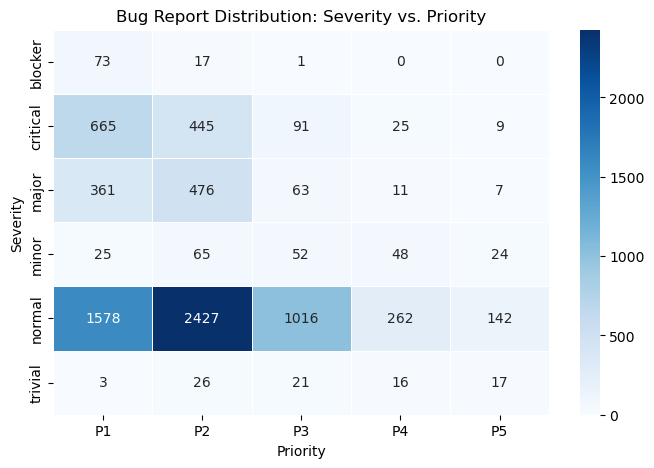

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample Bug Report Dataset
csv_file = "bug_reports_anonymized.csv"

df = pd.read_csv(csv_file)

### Count occurrences of (Severity, Priority) pairs
severity_priority_counts = df.groupby(["severity", "priority"]).size().unstack(fill_value=0)

### Plot Heatmap of Severity vs. Priority
plt.figure(figsize=(8, 5))
sns.heatmap(severity_priority_counts, annot=True, cmap="Blues", fmt="d", linewidths=0.5)
plt.title("Bug Report Distribution: Severity vs. Priority")
plt.xlabel("Priority")
plt.ylabel("Severity")
plt.show()

In [31]:
severity_mapping = {"blocker": 0, "critical": 1, "major": 2, "normal": 3, "minor": 4, "trivial": 5}
priority_mapping = {"P1": 0, "P2": 1, "P3": 2, "P4": 3, "P5": 4}

df["Severity_Num"] = df["severity"].map(severity_mapping)
df["Priority_Num"] = df["priority"].map(priority_mapping)

correlation = df[["Severity_Num", "Priority_Num"]].corr()
print(correlation)  # Check correlation coefficient


              Severity_Num  Priority_Num
Severity_Num      1.000000      0.277785
Priority_Num      0.277785      1.000000


In [32]:
from scipy.stats import chi2_contingency

chi2, p, _, _ = chi2_contingency(severity_priority_counts)
print(f"Chi-Square Test p-value: {p}")

if p < 0.05:
    print("Severity and Priority are statistically related.")
else:
    print("No significant relationship between Severity and Priority.")


Chi-Square Test p-value: 1.9759015332848124e-189
Severity and Priority are statistically related.


In [34]:
# Group by 'Severity' and calculate the most frequent 'Priority' for each severity
severity_priority_mapping = df.groupby("severity")["priority"].agg(lambda x: x.mode()[0]).to_dict()
print(severity_mapping)

{'blocker': 0, 'critical': 1, 'major': 2, 'normal': 3, 'minor': 4, 'trivial': 5}


In [35]:
# Map missing 'Priority' values based on the Severity-Priority relationship
df["Priority_Imputed"] = df.apply(
    lambda row: severity_priority_mapping.get(row["severity"]) if pd.isna(row["priority"]) else row["priority"],
    axis=1
)


In [37]:
df.head()

,bug_id,description,developer,severity,priority,project,Severity_Num,Priority_Num,Priority_Imputed
0,323798,Keyword URL Needs to be localized,developer_001,normal,P1,Firefox,3,0,P1
1,322369,History importer,developer_002,normal,P1,Firefox,3,0,P1
2,324237,Close button on tabs show empty tooltip,developer_003,minor,P3,Firefox,4,2,P3
3,323472,Crash when Places imports FF1.5 bookmarks,developer_002,critical,P1,Firefox,1,0,P1
4,322290,Queries in the bookmark toolbar/menu don't act...,developer_004,major,P2,Firefox,2,1,P2


In [38]:
# Save the updated dataset to a new CSV file
output_file = "imputed_bug_reports.csv"
df.to_csv(output_file, index=False)

print(f"Imputed dataset saved as: {output_file}")

Imputed dataset saved as: imputed_bug_reports.csv
